In [1]:
""""implements a dqn agent to maximise the reward using the gym_tranding environment"""

""" definitions:
Environment : Asset Market in this case the BCT to USD market (using Binance data)
Agent : Trading Algorithm that uses the environment to perform trading actions and maximise reward
State : Historical Price, Volume & Volatility Data of the asset
Agent Actions : Buy, Sell, Do Nothing (Hold)
Reward : Next period returns based on the action chosen and final return of the portfolio. 
Profit : The final return of the portfolio at the end of the trading period"""

import gym_trading_env
import gym_trading_env.utils.history as history
from gym_trading_env.utils.history import History
from gym_trading_env.utils import history
from gym_trading_env.environments import TradingEnv
from gym_trading_env.utils.download_data import download_data
import gymnasium as gym
import numpy as np  
import pandas as pd
import datetime
import torch.nn as nn
import torch.optim as optim
import torch as T
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

In [2]:
# Download BTC/USDT historical data from Binance and stores it to directory ./data/binance-BTCUSDT-1h.pkl
download_data(exchange_names = ["binance"],
    symbols= ["BTC/USDT"],
    timeframe= "1h",
    dir = "/Users/laura.barbosa/Downloads/",
    since= datetime.datetime(year= 2020, month= 1, day=1),
)
# Import your fresh data
df = pd.read_pickle("/Users/laura.barbosa/Downloads/binance-BTCUSDT-1h.pkl")

In [3]:
#investigate the data to check for any preprocessing needed

#make the df to have a different amount of rows
#df = df[:3000]
df

,open,high,low,close,volume,date_close
date_open,,,,,,
2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,2020-01-01 01:00:00
2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,2020-01-01 02:00:00
2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,2020-01-01 03:00:00
2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,2020-01-01 04:00:00
2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,2020-01-01 05:00:00
...,...,...,...,...,...,...
2023-08-09 09:00:00,29836.39,29836.40,29779.13,29781.78,1065.099370,2023-08-09 10:00:00
2023-08-09 10:00:00,29781.77,29854.71,29740.01,29842.45,1033.090010,2023-08-09 11:00:00
2023-08-09 11:00:00,29842.45,29914.19,29795.20,29888.32,1416.399900,2023-08-09 12:00:00


In [4]:
# Generating features based on suggestion from library
def preprocess(df : pd.DataFrame):
    df["feature_close"] = df["close"].pct_change()
    df["feature_open"] = df["open"]/df["close"]
    df["feature_high"] = df["high"]/df["close"]
    df["feature_low"] = df["low"]/df["close"]
    df["feature_volume"] = df["volume"] / df["volume"].rolling(7*24).max()
    df.dropna(inplace= True)
    return df

#call the function to generate the features
df = preprocess(df)

def reward_function(history):
    """Create reward function with the history object, it compares the two more recent portfolio valuations 
    and take the log of the ratio this is to incentivize the agent to trade in the future """

    portfolio_valuations = history["portfolio_valuation"]
    current_valuation = portfolio_valuations[-1]
    previous_valuation = portfolio_valuations[-2]

    if current_valuation > 0 and previous_valuation > 0:
        reward = np.log(current_valuation / previous_valuation)  # Set a positive reward in case of positive valuations, use the log to scale the reward
    else:
        reward = 0  # Set a default reward in case of non-positive valuations
    
    return reward

#set the additional required parameters for the reward function
portfolio = gym_trading_env.utils.portfolio.Portfolio(1000, 0.01/100, 0.0003/100)   
history = gym_trading_env.utils.history.History(reward_function) #reward_function = reward_function 




In [5]:

#define the environmnet
env = gym.make("TradingEnv",
        name= "BTCUSD",
        df = df, # defining the state space which includes: open, high, low, close, volume, feature_close, feature_open, feature_high, feature_low
        positions = [ -1, 0, 1], #definiing the action space -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate = 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        windows = 730, # Number of previous timesteps to consider, setting it to 1 month
        initial_position = 0, # Initial position
        verbose = 1,
        reward_function = reward_function
    )

#add History to the environment
history = History(max_size=10000)

#add metrics to the environment
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )
env.unwrapped.add_metric('Profit', lambda history: history['portfolio_valuation'][-1] - history['portfolio_valuation'][0])
env.unwrapped.add_metric('Profit (%)', lambda history: (history['portfolio_valuation'][-1] - history['portfolio_valuation'][0])/history['portfolio_valuation'][0] )
env.unwrapped.add_metric('Portfolio Value', lambda history : history['portfolio_valuation'][-1] )
env.unwrapped.add_metric('Portfolio Value Change', lambda history : history['portfolio_valuation'][-1] - history['portfolio_valuation'][0] )
env.unwrapped.add_metric('Portfolio Value Change (%)', lambda history : (history['portfolio_valuation'][-1] - history['portfolio_valuation'][0])/history['portfolio_valuation'][0] )


#check the inititial state of the environment
env.reset()
env.step(0)

(array([[ 0.03517865,  0.9660927 ,  1.0027491 , ...,  0.98936653,
          0.        ,  0.        ],
        [-0.00722264,  1.0071211 ,  1.0092248 , ...,  0.65946186,
          0.        ,  0.        ],
        [-0.01102985,  1.011154  ,  1.017323  , ...,  0.3584984 ,
          0.        ,  0.        ],
        ...,
        [ 0.00225875,  0.99774635,  1.0008335 , ...,  0.20948946,
          0.        ,  0.        ],
        [-0.00293313,  1.0029417 ,  1.0039066 , ...,  0.19243005,
          0.        ,  0.        ],
        [ 0.00208737,  0.997916  ,  1.0016868 , ...,  0.19647782,
         -1.        , -1.0041895 ]], dtype=float32),
 -0.0021925556622356323,
 False,
 False,
 {'idx': 730,
  'step': 1,
  'date': numpy.datetime64('2020-02-07T09:00:00.000000000'),
  'position_index': 0,
  'position': -1,
  'real_position': -1.0041895031898356,
  'data_volume': 1713.890217,
  'data_open': 9773.07,
  'data_date_close': Timestamp('2020-02-07 10:00:00'),
  'data_close': 9793.48,
  'data_low': 

In [6]:
# Run an episode until it ends :
#done, truncated = False, False
#observation, info = env.reset()
#while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
#    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
#    observation, reward, done, truncated, info = env.step(position_index)

#print(len(env.env._price_array))
#print(env.env._nb_features)
#print(env.env._price_array[0])
#print(env.env._info_array[0])


#env.reset()
#print(env.step(0))
#env.reset()



In [7]:

#create a memory replay buffer class
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size # maximum size of memory
        self.mem_cntr = 0 # memory counter
        self.state_memory = np.zeros((self.mem_size, *input_shape)) # state memory
        self.new_state_memory = np.zeros((self.mem_size, *input_shape)) # new state memory
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32) # action memory (now an array of integers)
        self.reward_memory = np.zeros(self.mem_size) # reward memory
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_) # terminal state memory      
        
    def store_transition(self, state, action, reward, state_, done):
        # store transition in memory
        index = self.mem_cntr % self.mem_size # index of memory
        self.state_memory[index] = state # store state
        self.new_state_memory[index] = state_ # store new state
        self.action_memory[index] = action # store action as an integer (no need for one-hot encoding)
        self.reward_memory[index] = reward # store reward
        self.terminal_memory[index] = done # store terminal state
        self.mem_cntr += 1 # increment memory counter
        
    def sample_buffer(self, batch_size):
        # sample a batch of data from memory
        max_mem = min(self.mem_cntr, self.mem_size) # get the maximum memory
        batch = np.random.choice(max_mem, batch_size, replace=False) # get a random batch of memory
        states = np.array([self.state_memory[i] for i in batch])  # Convert to a NumPy array
        states_ = np.array([self.new_state_memory[i] for i in batch])  # Convert to a NumPy array
        actions = self.action_memory[batch] # get the actions (now an array of integers)
        rewards = self.reward_memory[batch] # get the rewards
        terminal = self.terminal_memory[batch] # get the terminal states

        return states, actions, rewards, states_, terminal

        
#build a deep q network agent class
class Agent:
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size, input_dims, mem_size=100000, eps_min=0.01, eps_dec=5e-7, replace=1000, chkpt_dir='tmp/dqn'):
        self.action_space = list(range(n_actions)) #action space
        self.gamma = gamma #discount factor
        self.epsilon = epsilon #epsilon
        self.eps_min = eps_min #minimum epsilon
        self.eps_dec = eps_dec #epsilon decrement
        self.replace_target_cnt = replace #replace target network counter (how often we replace the target network)
        self.batch_size = batch_size #batch size for training
        self.learn_step_counter = 0 #learn step counter
        self.memory = ReplayBuffer(mem_size, [730, 7], n_actions) #create a memory replay buffer using the size, the input shape, and the number of actions
        self.q_eval = DeepQNetwork(n_actions=n_actions, input_dims=input_dims, #create a deep q network for evaluation
                                   lr=lr, name='q_eval', chkpt_dir=chkpt_dir)
        self.q_next = DeepQNetwork(n_actions=n_actions, input_dims=input_dims, #create a deep q network for next states
                                   lr=lr, name='q_next', chkpt_dir=chkpt_dir)   

    def store_transition(self, state, action, reward, state_, done):
        """We need to store the trasiitons of the agent in memory, so states and actions are preserved"""
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1


    def choose_action(self, observation):
        """We need to choose an action. We need to convert the observation
        into a tensor and send it to the GPU. We then need to generate a random
        number between 0 and 1. If the random number is less than epsilon, then
        we need to return a random action. Otherwise, we need to return the
        action with the highest Q-value."""

        if np.random.random() <= self.epsilon:
            #if random number is less than epsilon, return a random action
            return np.random.choice(self.action_space)
        
        #otherwise, return the action with the highest Q-value
        state = T.tensor(observation, dtype=T.float32).to(self.q_eval.device) #convert observation to a tensor of type float32
        actions = self.q_eval.forward(state) #get the actions from the q_eval network
        action = T.argmax(actions).item() #get the action with the highest Q-value

        # Ensure action is within the valid range of actions
        action = max(-1, min(2, action)) 
        return action


    def replace_target_network(self):
        """As per the DQN paper, we need to replace the target network, 
        which  is the q_next network, with the q_eval network"""
        if self.learn_step_counter % self.replace_target_cnt == 0: #if the learn step counter is divisible by the replace target counter
            self.q_next.load_state_dict(self.q_eval.state_dict()) #replace the q_next network with the q_eval network   


    def decrement_epsilon(self):
        """We need to decrement epsilon so that we don't get stuck in a local
        minimum. We also need to make sure that the minimum epsilon is
        not below zero.
        """
        #decrement epsilon
        self.epsilon = self.epsilon - self.eps_dec  
        if self.epsilon > self.eps_min:
            self.epsilon = self.epsilon - self.eps_dec
        else:
            self.eps_min

    def learn(self):
        """In order to learn, we need to sample a batch of data from memory.
        We then need to convert the data into tensors and send them to the GPU, 
        We then need to zero the gradients of the optimizer for the q_eval network.
        We then need to replace the target network.
        We then need to get the q values for the current states and the next states.
        We then need to get the max q values for the next states."""

        if self.memory.mem_cntr < self.batch_size:
            #if memory counter is less than batch size, return
            return

        self.q_eval.optimizer.zero_grad() #zero gradients of optimizer for q_eval network (reset gradients)
        self.replace_target_network() #replace target network

        states, actions, rewards, states_, terminal = self.memory.sample_buffer(self.batch_size)

        #general conversion of data to tensors and send to GPU/CPU
        states = T.tensor(np.array(states)).to(self.q_eval.device)  
        actions = T.tensor(actions).to(self.q_eval.device) 
        rewards = T.tensor(rewards).to(self.q_eval.device) 
        states_ = T.tensor(np.array(states_)).to(self.q_eval.device) 
        terminal = T.tensor(terminal).to(self.q_eval.device) 

        # Get the Q-values for the current states
        q_eval = self.q_eval.forward(states)

        # Select the Q-values corresponding to the taken actions
        q_pred = q_eval[T.arange(self.batch_size), actions].to(self.q_eval.device)
        q_next_values = self.q_next.forward(states_)
        q_next = q_next_values.max(dim=1)[0]

        # Get the maximum Q-values for the next states from target network
        q_next = self.q_next.forward(states_).max(dim=1)[0]
        q_next = q_next.squeeze(1)  # Expand dimensions along the action dimension

        # Expand the dimensions of rewards to match the shape of q_next
        expanded_rewards = rewards[:, None]

        # Set Q-value to 0 for terminal states
        q_next[terminal] = 0.0

        # Compute the target Q-value
        q_target = expanded_rewards + self.gamma * q_next

        # Convert to double to prevent overflow
        q_target = q_target.double()
        q_pred = q_pred.double()

        # Compute loss and backpropagate
        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device) #compute the loss by taking the mean squared error between q_target and q_pred
        loss.backward() #backpropagate the loss

        # Update the weights of the network
        self.q_eval.optimizer.step() #update the weights of the network using the optimizer step
        self.learn_step_counter += 1 #increment the learn step counter so we know when to replace the target network
        self.decrement_epsilon() #decrement epsilon so that the agent will take less random actions

#build a deep q network class
class DeepQNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, lr, name, chkpt_dir):
        super(DeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128) #fully connected layer 1 with 128 neurons, 128 is a random number
        self.fc2 = nn.Linear(128, 128) #fully connected layer 2 with 128 neurons
        self.fc3 = nn.Linear(128, n_actions) #fully connected layer 3 with n_actions neurons

        self.optimizer = optim.Adam(self.parameters(), lr=lr) #adam optimizer
        self.loss = nn.MSELoss()  # Set Mean squared error loss
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu') #gpu or cpu
        self.to(self.device) #move to gpu or cpu
  
    def forward(self, state): #forward pass
        state = state.float() #convert to float
        layer1 = F.relu(self.fc1(state)) #relu activation function for layer 1
        layer2 = F.relu(self.fc2(layer1)) #relu activation function for layer 2 
        return self.fc3(layer2) #return layer 3


# Define training parameters
lr = 0.001
input_dims = [env.observation_space.shape[1]]
eps_history = []
length = 1000
rewards = 0
episode_length = 3 # Length of each episode

# Create agent and set the number of episodes
agent = Agent(gamma=0.99, epsilon=1.0, lr=lr, input_dims=input_dims, n_actions=3, batch_size=64, eps_min=0.01, eps_dec=0.996, replace=100)

# Create history object to store data during training
history.set(episode_length=length, rewards=rewards)

# Training loop
for _ in range(episode_length):
    done = False
    observation_tuple = env.reset()
    observation = observation_tuple[0]
    while not done:
        action = agent.choose_action(observation)
        try:
            observation_, reward, done, _, info = env.step(action)
            observation_ = observation_[0]
            agent.memory.store_transition(np.array(observation), action, reward, np.array(observation_), done)  # Convert to numpy arrays
            agent.learn()
            observation = observation_
            eps_history.append(agent.epsilon)
            history.add(episode_length=episode_length, rewards=reward)
        except IndexError:
            done = True
    env.reset()


Market Return : 107.91%   |   Portfolio Return : -100.49%   |   Position Changes : 41   |   Episode Length : 7505   |   Profit : -1004.9019276286164   |   Profit (%) : -1.0049019276286164   |   Portfolio Value : -4.901927628616379   |   Portfolio Value Change : -1004.9019276286164   |   Portfolio Value Change (%) : -1.0049019276286164   |   


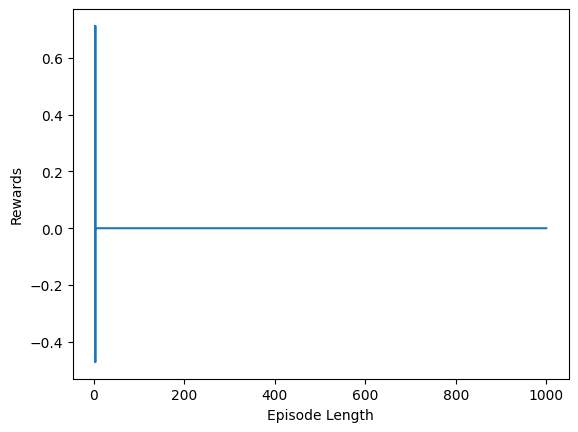

In [8]:
#plot episodes vs rewards
plt.plot(history['episode_length'], history['rewards'])
plt.xlabel('Episode Length')
plt.ylabel('Rewards')
plt.show()
